In [6]:
# Import necessary libraries
import pandas as pd
import numpy as np
import re
import nltk
import torch
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from transformers import AutoTokenizer, AutoModel, AutoModelForSeq2SeqLM
from sklearn.metrics.pairwise import cosine_similarity
from nltk.corpus import stopwords

# Download NLTK data (if not already downloaded)
nltk.download('punkt')
nltk.download('stopwords')

# Set device
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


[nltk_data] Downloading package punkt to /home/andersho/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/andersho/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
# Initialize tokenizers and models
embedding_tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
embedding_model = AutoModel.from_pretrained('distilbert-base-uncased')
embedding_model.to(DEVICE)

# Define stop words
STOP_WORDS = set(stopwords.words('english'))

# Directory paths
OUTFITS_DATA_PATH = 'vibrent/outfits.csv'
PICTURE_TRIPLETS_PATH = 'vibrent/picture_triplets.csv'
IMAGE_DIR = 'vibrent/images/'

# Load and preprocess data
def load_and_preprocess_data():
    # Load outfits data
    df_outfits = pd.read_csv(
        OUTFITS_DATA_PATH,
        delimiter=';',
        quotechar='"',
        escapechar='\\',
        encoding='utf-8',
        engine='python',
        on_bad_lines='skip',
        dtype=str,
    )

    # Load picture triplets data
    df_pictures = pd.read_csv(
        PICTURE_TRIPLETS_PATH,
        delimiter=';',
        quotechar='"',
        escapechar='\\',
        encoding='utf-8',
        engine='python',
        dtype=str,
    )

    # Clean column names, remove leading and trailing whitespace if present
    df_outfits.columns = df_outfits.columns.str.strip()
    df_pictures.columns = df_pictures.columns.str.strip()

    # Ensure all string columns are properly formatted in outfits df. Remove leading and trailing whitespace
    string_columns = ['id', 'name', 'group', 'owner', 'description', 'outfit_tags', 'tag_categories']
    for col in string_columns:
        if col in df_outfits.columns:
            df_outfits[col] = df_outfits[col].astype(str).str.strip()

    # Merge the outfits DataFrame with the pictures DataFrame on 'id'
    df_merged = pd.merge(df_outfits, df_pictures, how='left', left_on='id', right_on='outfit.id')

    # Drop rows where 'file_name' is missing
    df_merged.dropna(subset=['file_name'], inplace=True)

    # Construct image paths
    df_merged['image_path'] = df_merged['file_name'].apply(lambda x: os.path.join(IMAGE_DIR, x))

    # Check if image files exist and filter
    df_merged['image_exists'] = df_merged['image_path'].apply(os.path.isfile)
    df_merged = df_merged[df_merged['image_exists']].copy()

    # Group images by outfit ID
    df_images = df_merged.groupby('id')['image_path'].apply(list).reset_index()
    df = pd.merge(df_outfits, df_images, on='id', how='inner')

    # Drop rows with missing values in description
    df.dropna(subset=['description'], inplace=True)

    # Preprosses description
    def preprocess_text(text):
        if not isinstance(text, str):
            return ''
        # Convert to lowercase
        text = text.lower()
        # Remove special characters and numbers
        text = re.sub(r'[^a-z\s]', '', text)
        # Tokenize text into individual words
        tokens = nltk.word_tokenize(text)
        # Remove stop words
        tokens = [word for word in tokens if word not in STOP_WORDS]
        # Join tokens back into a single string
        return ' '.join(tokens)

    df['sanitized_description'] = df['description'].apply(preprocess_text)

    # Process outfit_tags into lists
    def parse_list_column(column):
        if isinstance(column, str):
            column = column.strip('[]')
            items = [item.strip(" '\"") for item in column.split(',')]
            return items
        elif isinstance(column, list):
            return column
        else:
            return []

    df['outfit_tags_list'] = df['outfit_tags'].apply(parse_list_column)

    # Remove entries with empty outfit_tags_list
    df = df[df['outfit_tags_list'].map(len) > 0].copy()

    # Make all the outfit tags lowercase
    df['sanitized_tags'] = df['outfit_tags_list'].apply(lambda tags: [tag.lower() for tag in tags])

    return df

2024-12-06 12:42:39.320628: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733488959.656620     151 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733488960.224883     151 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-06 12:42:41.044403: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
# Generate and cache embeddings
def generate_and_cache_embeddings(df):
    # Check if embeddings are already computed
    if 'description_embedding' in df.columns:
        print("Embeddings are already computed.")
        return df

    # Generate embeddings for outfit descriptions
    def get_embeddings(texts):
        inputs = embedding_tokenizer(
            texts,
            return_tensors='pt',
            truncation=True,
            padding=True,
            max_length=128
        ).to(DEVICE)
        with torch.no_grad():
            outputs = embedding_model(**inputs)
        return outputs.last_hidden_state.mean(dim=1).cpu()

    # Batch processing to generate embeddings
    batch_size = 32
    description_embeddings = []
    for i in range(0, len(df), batch_size):
        batch_texts = df['sanitized_description'].iloc[i:i+batch_size].tolist()
        embeddings = get_embeddings(batch_texts)
        description_embeddings.append(embeddings)
    # Concatenate all embeddings
    description_embeddings = torch.cat(description_embeddings, dim=0)
    df['description_embedding'] = list(description_embeddings)

    return df

# Function to generate embedding for user input
def get_user_embedding(user_input):
    preprocessed_input = preprocess_text(user_input)
    embedding = get_embeddings([preprocessed_input])
    return embedding, preprocessed_input

# Preprocess text (moved outside for reuse)
def preprocess_text(text):
    if not isinstance(text, str):
        return ''
    # Convert to lowercase
    text = text.lower()
    # Remove special characters and numbers
    text = re.sub(r'[^a-z\s]', '', text)
    # Tokenize text into individual words
    tokens = nltk.word_tokenize(text)
    # Remove stop words
    tokens = [word for word in tokens if word not in STOP_WORDS]
    # Join tokens back into a single string
    return ' '.join(tokens)

# Get embeddings (moved outside for reuse)
def get_embeddings(texts):
    inputs = embedding_tokenizer(
        texts,
        return_tensors='pt',
        truncation=True,
        padding=True,
        max_length=128
    ).to(DEVICE)
    with torch.no_grad():
        outputs = embedding_model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).cpu()

# Function to recommend outfits
def recommend_outfits(user_input_embedding, user_input_tokens, k=5):
    # Stack all embeddings into a matrix
    outfit_embeddings = torch.stack(df['description_embedding'].tolist())
    # Compute cosine similarity between user input and all outfit embeddings
    similarities = cosine_similarity(user_input_embedding.numpy(), outfit_embeddings.numpy())[0]

    # Compute tag matching score
    def tag_match_score(outfit_tags):
        return len(set(user_input_tokens).intersection(set(outfit_tags)))

    df['tag_match_score'] = df['sanitized_tags'].apply(tag_match_score)

    # Combine similarity scores and tag match scores with weights
    df['combined_score'] = 0.9 * similarities + 0.1 * df['tag_match_score']

    # Get outfits with positive combined scores
    matching_outfits = df[df['combined_score'] > 0]

    if matching_outfits.empty:
        return pd.DataFrame()

    # Sort outfits based on combined score
    top_outfits = matching_outfits.sort_values(by='combined_score', ascending=False).head(k)
    return top_outfits


In [9]:
# Function to display outfit
def display_outfit(row, user_input):
    print(f"\nOutfit ID: {row['id']}")
    print(f"Name: {row['name']}")
    print(f"Description: {row['description']}")
    print(f"Tags: {', '.join(row['outfit_tags_list'])}")

    # Show the first image
    image_paths = row['image_path']
    if image_paths and os.path.isfile(image_paths[0]):
        img = mpimg.imread(image_paths[0])
        plt.imshow(img)
        plt.axis('off')
        plt.show()
    else:
        print("Image not available.")

    # Ask if the user wants to see more images
    if len(image_paths) > 1:
        show_more = input("Chatbot: Would you like to see more images of this outfit? (yes/no): ").strip().lower()
        if show_more in ['yes', 'y']:
            for img_path in image_paths[1:]:
                if os.path.isfile(img_path):
                    img = mpimg.imread(img_path)
                    plt.imshow(img)
                    plt.axis('off')
                    plt.show()
                else:
                    print("Image not available.")


In [11]:
# Chatbot function
def chatbot():
    print("Welcome to the Outfit Recommendation Chatbot!")
    print("You can describe what you're looking for, and I'll recommend some outfits.")
    print("Type 'exit', 'quit', or 'bye' to end the conversation.")
    while True:
        user_input = input("\nYou: ")
        if user_input.lower() in ['exit', 'quit', 'bye']:
            print("Chatbot: Thank you for using the Outfit Recommendation Chatbot!")
            break
        if not user_input.strip():
            print("Chatbot: Please describe what you're looking for.")
            continue

        # Preprocess user input
        user_embedding, preprocessed_input = get_user_embedding(user_input)
        user_input_tokens = preprocessed_input.split()

        # Recommend outfits
        recommended_outfits = recommend_outfits(user_embedding, user_input_tokens)

        if recommended_outfits.empty:
            print("Chatbot: Sorry, I couldn't find any outfits matching your description.")
            print("Chatbot: Try using different keywords or being more specific.")
            continue

        print("Chatbot: Based on your preferences, I recommend:")
        for idx, row in recommended_outfits.iterrows():
            display_outfit(row, user_input)
            # Ask if the user wants to see the next recommendation
            if idx != recommended_outfits.index[-1]:
                next_step = input("\nChatbot: Would you like to see another recommendation? (yes/no): ").strip().lower()
                if next_step not in ['yes', 'y']:
                    break
        print("Chatbot: Let me know if you'd like to see more recommendations or something different!")

# Load and preprocess data
df = load_and_preprocess_data()

# Generate and cache embeddings
df = generate_and_cache_embeddings(df)

Welcome to the Outfit Recommendation Chatbot!
You can describe what you're looking for, and I'll recommend some outfits.
Type 'exit', 'quit', or 'bye' to end the conversation.



You:  I would like a dress to wear for a formal party in summer in size small and pink


Chatbot: Based on your preferences, I recommend:

Outfit ID: outfit.ce41e7d1edf4406aa1e7dd6ae1905d88
Name: Donna Dress
Description: The Donna Dress from Billie & Me is a classy little number. Along with its shimmery shade of pink, this wrap dress features a deep v-neck, wide short sleeves and ties at the hip. Pair it with heels and dress it up or wear it with sneakers for a more casual look, either way works!
Tags: Pink, Maxi, Synthetic, Women, Spring, Billie & me, Dressed-up, Everyday, Summer, Dresses, Statement, Formal, S


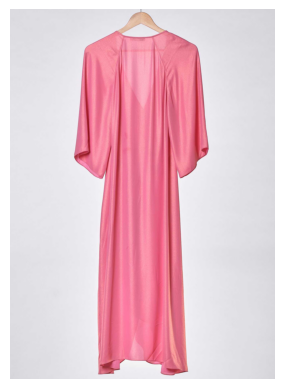

Chatbot: Would you like to see more images of this outfit? (yes/no):  no

Chatbot: Would you like to see another recommendation? (yes/no):  yes



Outfit ID: outfit.0a8b4788760a4124beb1b8e9c033b5f7
Name: Inyala Print Dress Eucalyptus
Description: The Inyala Print Dress from Rodebjer is a beautiful dress made in recycle polyester. It features a belt at the waist, where it can both bind behind the back or in front that makes a lovely pleated effect. The dress is slightly transparent, so you may need a slip dress underneath it it can easily be worn over jeans like a long tunic or as a light cardigan.
Tags: Synthetic, Pink, Rodebjer, Maxi, Formal, Dressed-up, Floral, Everyday, Dresses, Spring, Women, S, Summer


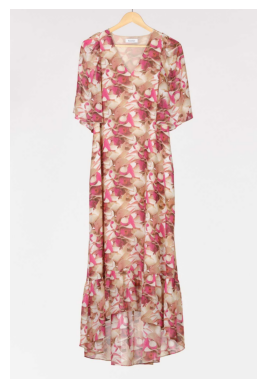

Chatbot: Would you like to see more images of this outfit? (yes/no):  no

Chatbot: Would you like to see another recommendation? (yes/no):  yes



Outfit ID: outfit.aec0d577c369498ca487c9b837a3d5e8
Name: Metzo Dress
Description: This gorgeous salmon Metzo Dress fits perfectly with the festivities of the season. The dress is simple with a v-neck and has a nice shape with a concealed zipper in the back.
Tags: Summer, Dressed-up, Women, Everyday, Pink, Formal, S, Riccovero, Synthetic, Maxi, Spring, Statement, Dresses


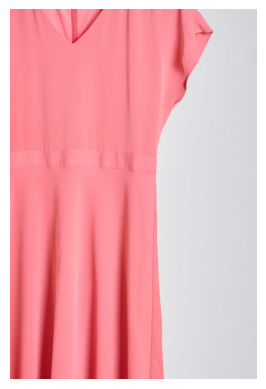

Chatbot: Would you like to see more images of this outfit? (yes/no):  no

Chatbot: Would you like to see another recommendation? (yes/no):  yes



Outfit ID: outfit.3619c49a78674b0bb3c2803ee199cd92
Name: Pink Floral Maxi Dress
Description: This beautiful draped maxi dress, features an exciting waistline and a cut-out in the back. The colors make it perfect for a spring/summer wedding.
Tags: Pink, Floral, Pia Tjelta byTiMo, Maxi, Summer, Women, Statement, M, Spring, Formal, Dresses, Viscose


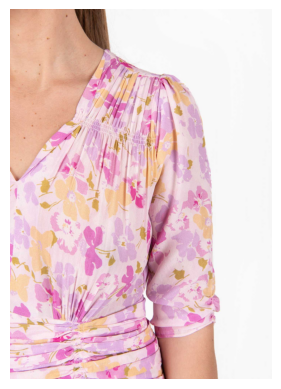

In [ ]:
# Start the chatbot
chatbot()